In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules


In [12]:
# Step 1: Load Data
data = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")

In [13]:
# Step 2: Clean Data
data.dropna(inplace=True)
data = data[~data['InvoiceNo'].astype(str).str.startswith('C')]
data = data[data['Quantity'] > 0]
data = data[data['UnitPrice'] > 0]


In [14]:
# Step 3: Add a TotalSum column first
data['TotalSum'] = data['Quantity'] * data['UnitPrice']

In [15]:
# Step 4: RFM Table Creation
import datetime
snapshot_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalSum': 'sum'
})
rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalSum': 'MonetaryValue'}, inplace=True)

In [16]:
# Step 5: Customer Segmentation using KMeans
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [17]:
# Step 6: Market Basket Analysis
basket = data[data['Country'] == 'United Kingdom']
basket = basket.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)
frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

C:\Users\aryan\AppData\Local\Temp\ipykernel_13596\57666431.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
C:\Users\aryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


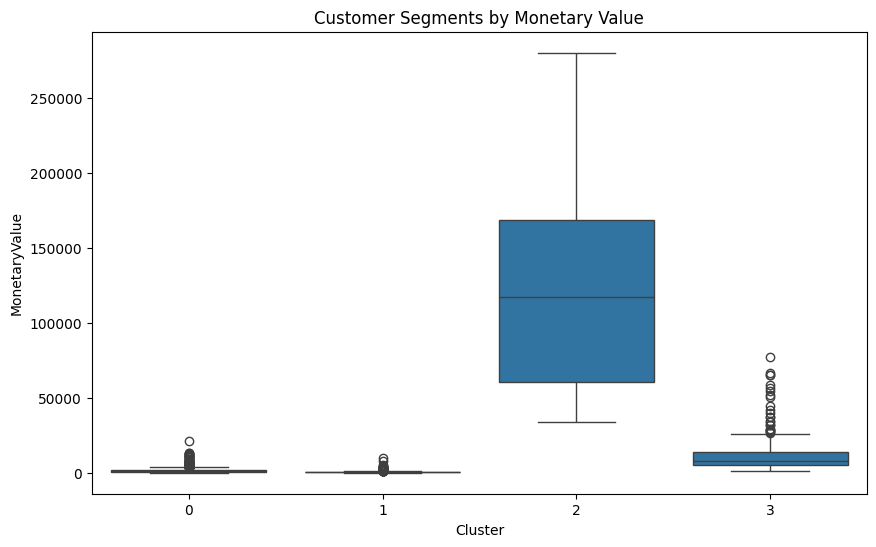

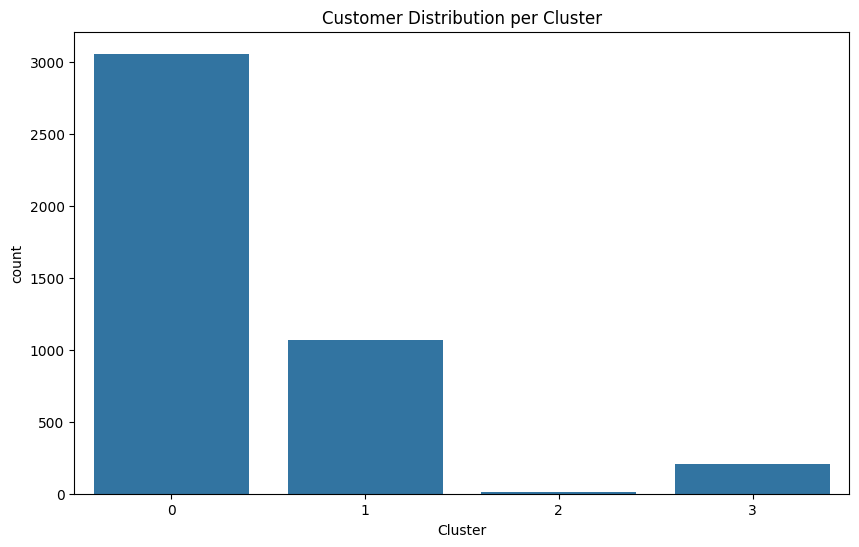

Top Market Basket Rules:
                                          antecedents  \
70  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
75                  (GREEN REGENCY TEACUP AND SAUCER)   
73                   (PINK REGENCY TEACUP AND SAUCER)   
72  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   
5                   (GREEN REGENCY TEACUP AND SAUCER)   

                                          consequents  antecedent support  \
70                  (GREEN REGENCY TEACUP AND SAUCER)            0.023009   
75  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...            0.036766   
73  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...            0.029617   
72                   (PINK REGENCY TEACUP AND SAUCER)            0.028595   
5                    (PINK REGENCY TEACUP AND SAUCER)            0.036766   

    consequent support   support  confidence       lift  representativity  \
70            0.036766  0.020485    0.890339  24.216650               1.0   
75            0

In [ ]:
# Step 7: Visualizations
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='MonetaryValue', data=rfm)
plt.title("Customer Segments by Monetary Value")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=rfm)
plt.title("Customer Distribution per Cluster")
plt.show()

# Display the top rules
print("Top Market Basket Rules:")
print(rules.sort_values(by='lift', ascending=False).head())
